# Vegetation Phenology

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook  gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) and dual-polarimetric decomposition (Alpha, Entropy and Anisotropy) for exploring annual vegetation dynamics.

This notebook also demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Scripts/deafrica_temporal_statistics.py).  To detect changes in plant life for Sentinel-2, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The dual-pol Radar Vegetation Index (RVI) and Entropy bands from Sentinel-1 will be compared  with Sentinel-2 NDVI for multi-temporal trends due to their relationship with vegetaton biomass. Monthly means for the RVI and Entropy bands will be generated and saved as a GeoTiff. Sentinel one date are indexed as product "S1_rtc" for radar backscatter.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load Sentinel-1 radar backscatter and cloud-masked Sentinel 2 data for an area of interest.
2. Apply speckle filtering 
3. Calculate dual-pol Radar Vegetation Index (RVI)
4. Load Sentinel-1 dual-pol decomposition data
5. Load Sentinel-2 data and calculate NDVI
6. Interactively compare RVI, Entropy the and NDVI timeseries
7. Show normal statistics
8. Generate monthly means for IBI and entropy
9. Save results to Geotech files

Following my need to be included: mouse press
3. Generate a zonal time series of vegetation health
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series
6. Calculate per-pixel phenology statistics
7. Optional: Calculating generic temporal statistics usng the hdstats library

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb

from datacube.utils.aws import configure_s3_access
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,lat,region_code,instrument,lon,format,creation_time,dataset_maturity,platform,time,product_family,label,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,
3,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [4]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = 22.817
lon = 28.518
lon_buffer = 0.0175
lat_buffer = 0.004

# Set the range of dates for the analysis
time_range = ('2020-01',"2020-12")

In [5]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)



## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-1 radar backscatter data and cloud-masked Sentinel-2 

The first step is to load Sentinel-1 radar backscatter data for the specified area of interest and time range. 
`dc.load()` function is used to return a time series of satellite images. The returned xarray.Dataset dataset will contain analysis ready images over agriculture field in South of Egypt. 

In [7]:
# Create a reusable query
query_S1 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'mask'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933'
}

# # Load available data from Sentinel-1
ds_S1 = dc.load(product='s1_rtc',
             **query_S1)

#creation of a new band (VH/VV=vhvv) for RGB display 
ds_S1['vhvv'] = ds_S1.vh.where(ds_S1.mask==1) / ds_S1.vv.where(ds_S1.mask==1)
print(ds_S1)

<xarray.Dataset>
Dimensions:      (time: 9, x: 170, y: 48)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-20T16:10:40.088953 ... 2020-12...
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.1641401 0.10866246 ... 0.005223699
    vh           (time, y, x) float32 0.027780188 0.037396476 ... 8.727944e-06
    mask         (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    vhvv         (time, y, x) float32 0.16924681 0.34415266 ... 0.001670836
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [8]:
# Create a reusable query
query_S2 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-10, 10),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-2
ds_S2 = dc.load(product='s2_l2a',
             **query_S2)

print(ds_S2)

<xarray.Dataset>
Dimensions:      (time: 73, x: 339, y: 95)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T08:53:48 ... 2020-12-27T08:...
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 3586 4096 4540 4844 ... 4972 4936 4936 5008
    green        (time, y, x) uint16 2404 2834 3162 3342 ... 3500 3484 3464 3520
    blue         (time, y, x) uint16 1572 1724 1874 1964 ... 2126 2152 2166 2144
    nir          (time, y, x) uint16 3990 4532 5064 5392 ... 5624 5640 5648 5736
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


**Once the load is complete**, we can plot some of the images as as a true-colour composite image using the `rgb` function.  

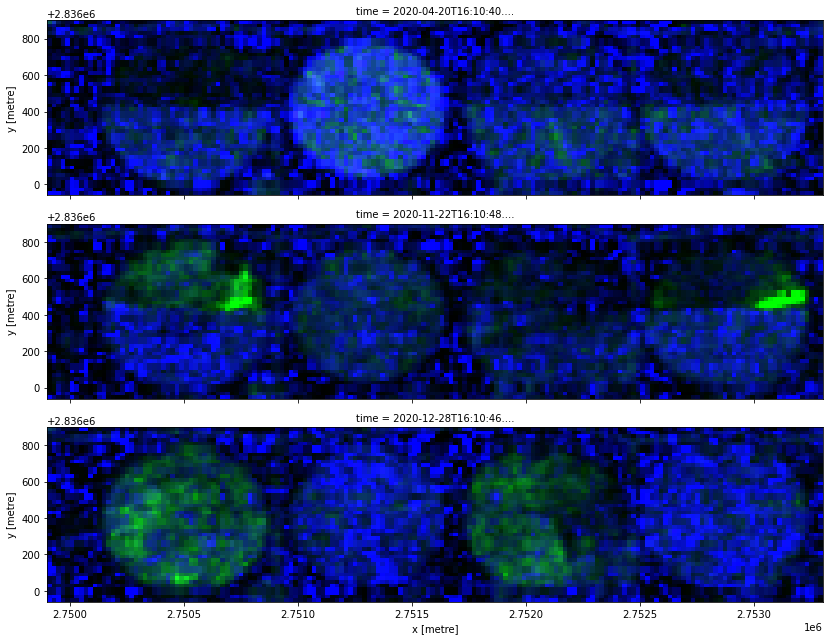

In [12]:
rgb(ds_S1.where(ds_S1.mask==1), bands=['vh','vv','vhvv'], index=[0,5,8], col_wrap=1, size=3)

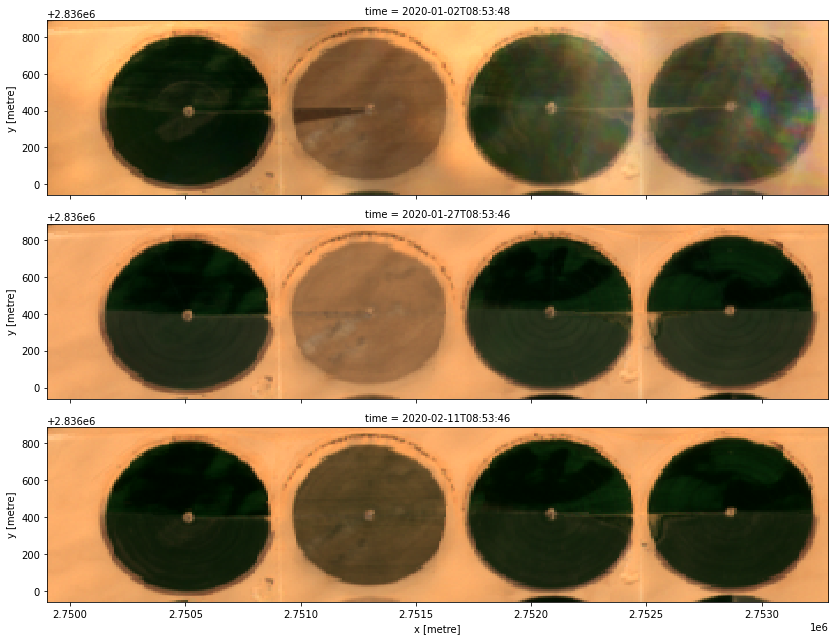

In [13]:
rgb(ds_S2, index=[0,5,8], col_wrap=1, size=3)

## Apply speckle filtering

The distortion you're seeing in Sentinel-1 imagery is a type of noise known as speckle, which gives the images a grainy appearence.
If we want to be able to easily decide whether any particular pixel is water or land, we need to reduce the chance of misinterpreting a water pixel as a land pixel due to the noise.

Speckle can be removed through filtering.
If interested, you can find a technical introduction to speckle filtering [here](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).
For now, it is enough to know that we can filter the data using the Python function defined in the next cell:

In [14]:
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [15]:
# Set any null values to 0 before applying the filter to prevent issues
ds_S1_filled = ds_S1.where(~ds_S1.isnull(), 0)

In [16]:
# Create new bands in dataset corresponding to filtered VV and VH data
filtered_vv= ds_S1_filled.vv.groupby("time").apply(lee_filter, size=7)
filtered_vh= ds_S1_filled.vh.groupby("time").apply(lee_filter, size=7)

In [17]:
#create smoothed dataset with Nans and assign attributes 
nodata_mask = ds_S1.isnull().to_array().any(axis=0)
smoothed = filtered_vv.to_dataset(name='vv')
smoothed['vh'] = filtered_vh
smoothed = smoothed.where(~nodata_mask)
smoothed.assign_attrs(ds_S1.attrs)
#smoothed

<xarray.Dataset>
Dimensions:      (time: 9, x: 170, y: 48)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-20T16:10:40.088953 ... 2020-12...
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.10195902 0.07449738 ... 0.008370334
    vh           (time, y, x) float32 0.015844438 0.018865325 ... 0.0023179068
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

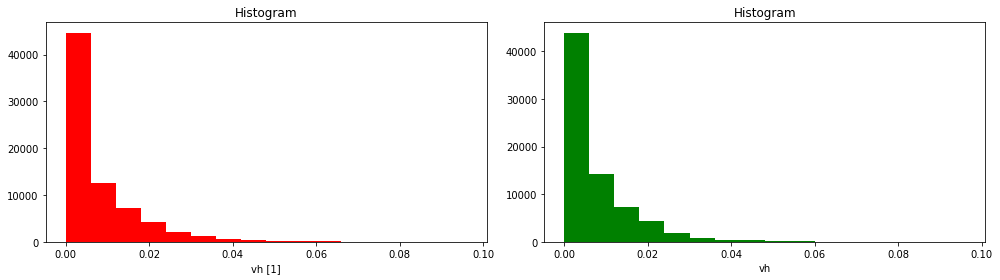

In [18]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ds_S1.vh.where(ds_S1.mask==1).plot.hist(ax=ax[0],bins=np.arange(0,0.1,0.006), facecolor='red')
smoothed.vh.plot.hist(ax=ax[1],bins=np.arange(0,0.1,0.006), facecolor='green')
plt.tight_layout()

## Calculate Dual-pol Radar Vegetation Index 

In [19]:
smoothed['RVI'] = 4 *smoothed.vh/(smoothed.vv + smoothed.vh)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.

In [20]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_S2 = calculate_indices(ds_S2, index=veg_proxy, collection='s2')

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


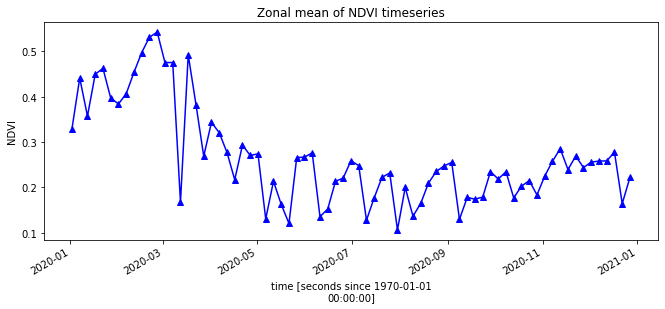

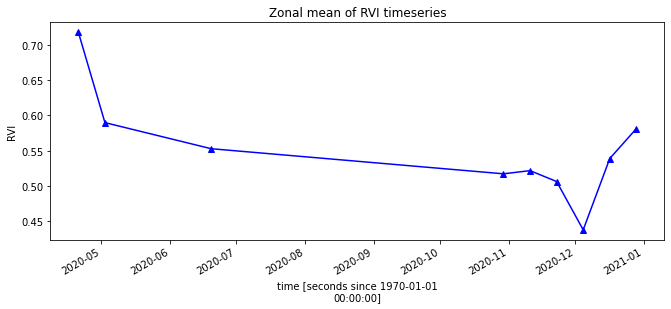

In [22]:
ds_S2.NDVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of NDVI timeseries');
smoothed.RVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of RVI timeseries');

## Interpolate vegetation time-series

Due to the infrequency of satellite passes or the presence of cloud obscuring the ground, our data may have gaps. `Xarray` has inbuilt methods such as `.interpolate_na()` to complete a time-series. While these functions are great for small datasets, they can become prohibitively slow at scale. DE Africa's custom function `fast_completion` will remove any `NaNs` (Not a Number) very quickly, even over relatively large datasets. 

We will test both methods below.

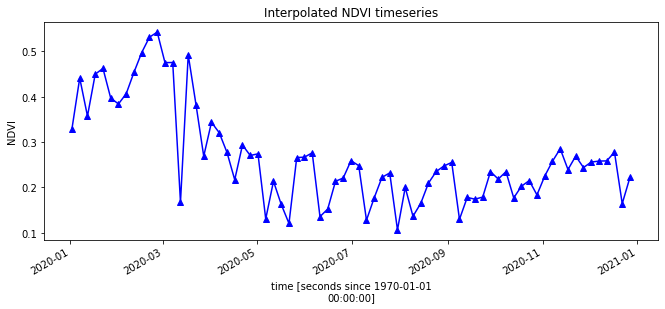

In [24]:
#fill missing values using xarray's interpolate_na() method
ds_S2.NDVI.interpolate_na(dim='time', method='linear').mean(['x', 'y']).plot.line('b-^', figsize=(11,4))

plt.title('Interpolated NDVI timeseries');

Alternatively, lets complete the timeseries using the DE Africa function `deafrica_temporal_statistics.fast_complete()`

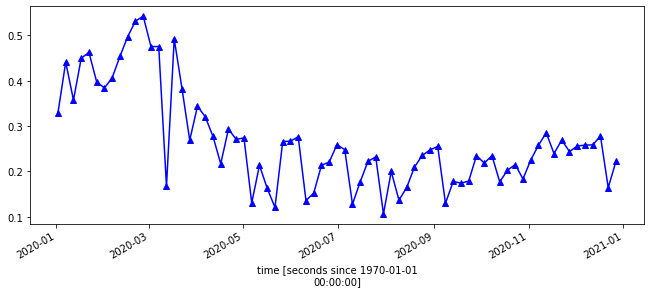

In [25]:
# complete timeseries using fast_completion
ndvi = ts.fast_completion(ds_S2.NDVI)

# # plot the result
ndvi.mean(['x','y']).plot.line('b-^', figsize=(11,4));

## Smoothing vegetation time-series

We may also wish to smooth a time series to remove noise. This can be accomplished in a number of ways, two of which we explore here.
1. By calculating a `xarray.rolling mean()` over a specified window-size. 
2. By applying the `deafrica_temporal_statistcs.smooth()` function, which relies on the `scipy.signal.wiener` filter.

Below we will demonstrate this by first calculating a `rolling mean` across every three time steps. The larger the window-size, the smoother the curve will be, but at the cost of more granular detail in the curve.

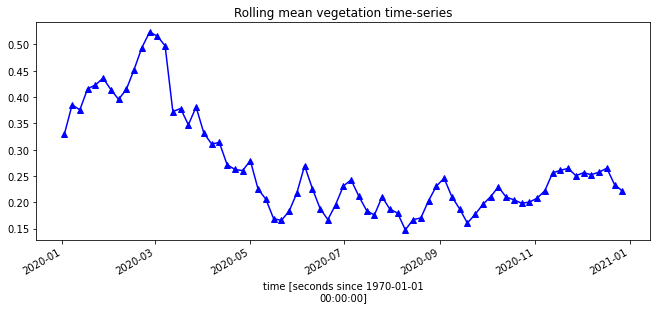

In [26]:
#smooth the data
ndvi_rolling = ndvi.mean(['x', 'y']).rolling(time=3, min_periods=1).mean()

#plot the smoothed data
ndvi_rolling.plot.line('b-^', figsize=(11, 4))
plt.title('Rolling mean vegetation time-series');

 Alternatively, lets smooth the timeseries using `deafrica_temporal_statistcs.smooth()`

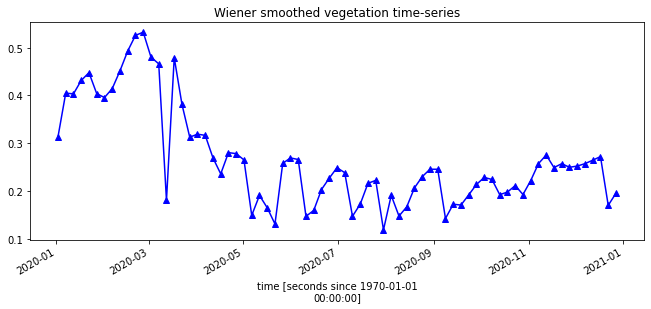

In [27]:
#smooth the data
ndvi_smooth = ts.smooth(ndvi)

#plot the smoothed data
ndvi_smooth.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title("Wiener smoothed vegetation time-series");

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

where DOY = day-of-year (Jan 1st = 0, Dec 31st = 365).  By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating and/or smoothing the time-series in the same way as we did above, the interpolating/smoothing will occur before the statistics are calculated. 

See the [deafrica_temporal_statistics](../Scripts/deafrica_temporal_statistics.py) script for more information on each of the parameters in `xr_phenology`.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

In [28]:
#calculate phenology on the zonal mean of the dataset
zonal_phen = ts.xr_phenology(
        ds_S2.NDVI.mean(['x', 'y']),
        stats=['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS'],
        method_sos="first",
        method_eos="last",
        complete="linear",
        smoothing="rolling_mean")

print(zonal_phen)

Completing using linear interp...
   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         vSOS
         vPOS
         vEOS
<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 6933
Data variables:
    SOS          int16 2
    POS          int16 57
    EOS          int16 222
    vSOS         float32 0.32932207
    vPOS         float32 0.523411
    vEOS         float32 0.14746876


Plot the results with our statistcs annotated on the plot

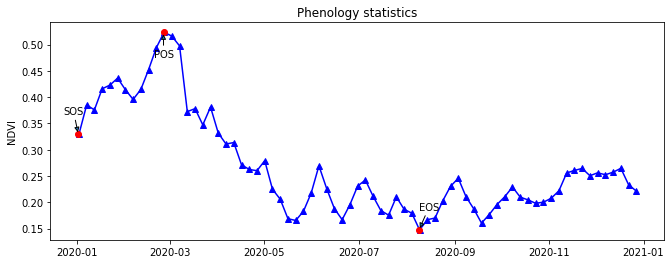

In [29]:
# Use DOY results to create a datetime object
year = str(ds_S2.time.dt.year.values[0]) + " "
eos_dt = dt.datetime.strptime(year + str(zonal_phen.EOS.values), '%Y %j')
sos_dt = dt.datetime.strptime(year + str(zonal_phen.SOS.values), '%Y %j')
pos_dt = dt.datetime.strptime(year + str(zonal_phen.POS.values), '%Y %j')

#create plot
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(ndvi_rolling.time, ndvi_rolling, 'b-^')

#add start of season
ax.plot(sos_dt, zonal_phen.vSOS, 'or')
ax.annotate('SOS',
            xy=(sos_dt, zonal_phen.vSOS.values),
            xytext=(-15, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

#add end of season
ax.plot(eos_dt, zonal_phen.vEOS, 'or')
ax.annotate('EOS',
            xy=(eos_dt, zonal_phen.vEOS.values),
            xytext=(0, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

#add peak of season
ax.plot(pos_dt, zonal_phen.vPOS, 'or')
ax.annotate('POS',
            xy=(pos_dt, zonal_phen.vPOS.values),
            xytext=(-10, -25),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

plt.ylabel('NDVI')
plt.title('Phenology statistics');

### Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results. In the code below we have changed the `method_eos` and `method_sos` parameters to `'median'`, this will estimate the beginning and end of the growing seasons as the median value of the slopes on the each side of the curve. The code below also demonstrates using the `fast_complete` and `wiener` methods for gap-filling and smoothing.

In [30]:
#calculate phenology stats on every pixel in dataset
phen = ts.xr_phenology(
        ds_S2.NDVI,
        method_sos='median',
        method_eos='median',
        complete='fast_complete',
        smoothing='wiener'
    ).compute()

print(phen)

Completing using fast_complete...
   Smoothing with wiener filter...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
<xarray.Dataset>
Dimensions:      (x: 339, y: 95)
Coordinates:
  * x            (x) float64 2.75e+06 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * y            (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
    spatial_ref  int32 0
Data variables:
    SOS          (y, x) int16 27 12 32 32 32 42 27 37 ... 27 37 37 57 37 37 47
    POS          (y, x) int16 67 62 92 92 92 92 92 87 ... 92 92 92 87 92 92 92
    EOS          (y, x) int16 182 177 287 292 297 277 ... 257 352 222 252 202
    Trough       (y, x) float32 0.045800038 0.044900868 ... 0.03321037
    vSOS         (y, x) float32 0.08225847 0.074478365 ... 0.06775661 0.06728728
    vPOS         (y, x) float32 0.48850203 0.25735602 ... 0.09820131 0.096831694
    vEOS         (y, x) float32 0.091331184 0.0839

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

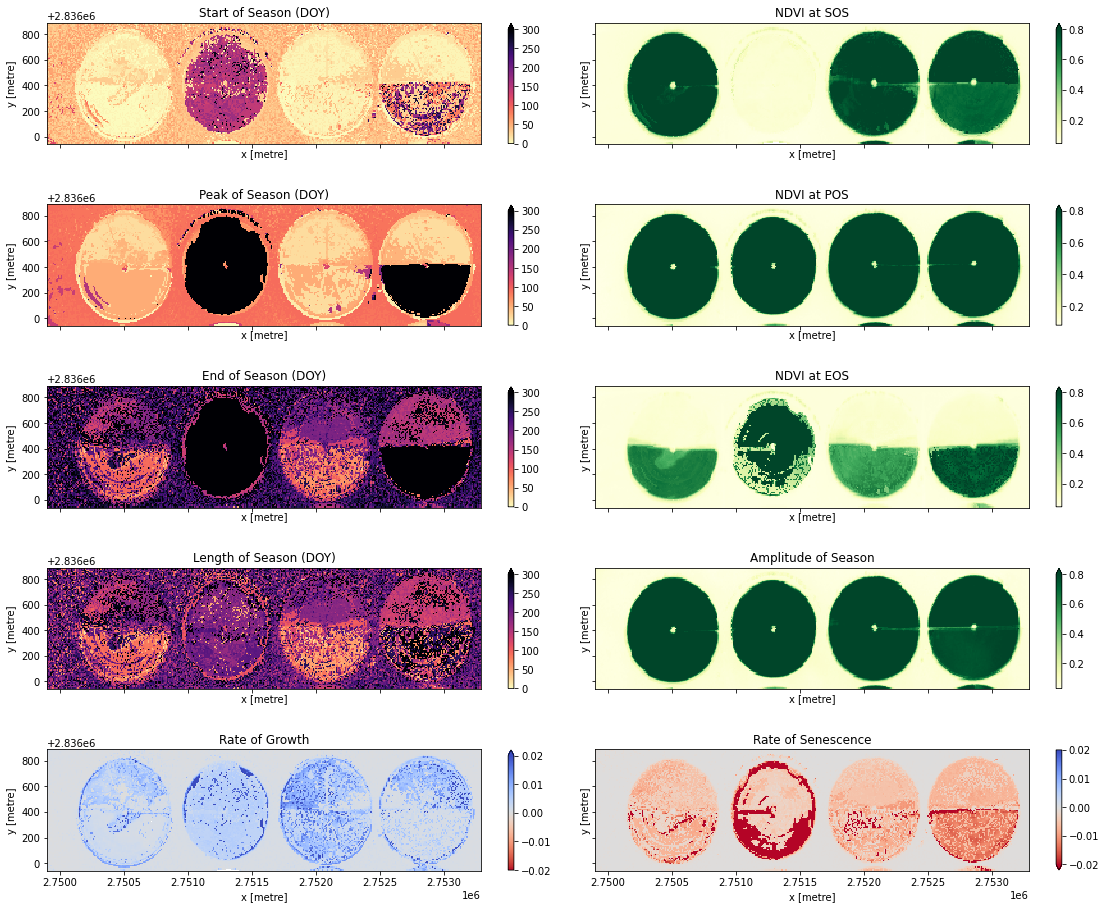

In [31]:
# set up figure
fig, ax = plt.subplots(nrows=5,
                       ncols=2,
                       figsize=(16, 13),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy+' at SOS')

# peak of season
phen.POS.plot(ax=ax[1, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title(veg_proxy+' at POS')

# end of season
phen.EOS.plot(ax=ax[2, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 1].set_title(veg_proxy+' at EOS')

# Length of Season
phen.LOS.plot(ax=ax[3, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 0].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[3, 1],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 1].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot(ax=ax[4, 0],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 0].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot(ax=ax[4, 1],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 1].set_title('Rate of Senescence')

plt.tight_layout();

## Advanced: Calculating generic temporal statistics

In addition to the `xr_phenology` function, the DE Africa [deafrica_temporal_statistics](../Scripts/deafrica_temporal_statistics.py) script contains another function for calculating generic time-series statistics, `temporal_statistics`.  This function is built upon the [hdstats library](https://github.com/daleroberts/hdstats) (a library of multivariate and high-dimensional statistics algorithms).
This function accepts a 2 or 3D time-series of, for example, NDVI, and computes a number of summary statistics including:
- discordance
- discrete fourier transform coefficients (mean, std, and median)
- median change
- absolute change
- complexity
- central difference
- number of peaks (very slow to run)

Below we will calculate a number of these statistics and plot them.

In [32]:
statistics = ['discordance',
             'f_mean',
             'median_change',
             'abs_change',
             'complexity',
             'central_diff']

ts_stats = ts.temporal_statistics(ds_S2.NDVI, statistics)
print(ts_stats)

Completing...
   Statistics:
      discordance
      f_mean
      median_change
      abs_change
      complexity
      central_diff
<xarray.Dataset>
Dimensions:        (x: 339, y: 95)
Coordinates:
  * x              (x) float64 2.75e+06 2.75e+06 ... 2.753e+06 2.753e+06
  * y              (y) float64 2.837e+06 2.837e+06 ... 2.836e+06 2.836e+06
Data variables:
    discordance    (y, x) float64 -0.1262 -0.1669 -0.188 ... -0.1991 -0.1994
    f_mean_n1      (y, x) float32 1.9922508 0.9831419 ... 0.16737294 0.16930461
    f_mean_n2      (y, x) float32 0.8150908 0.33822435 ... 0.07017317
    f_mean_n3      (y, x) float32 0.39986703 0.27567005 ... 0.060411192
    median_change  (y, x) float64 -0.0006885 0.004639 ... -0.0009701 -0.0003358
    abs_change     (y, x) float64 0.05404 0.03162 0.01618 ... 0.009527 0.009289
    complexity     (y, x) float64 48.9 50.04 44.33 42.25 ... 88.32 86.02 77.33
    central_diff   (y, x) float64 0.0005534 -0.0001917 ... -0.000295 -0.0003538


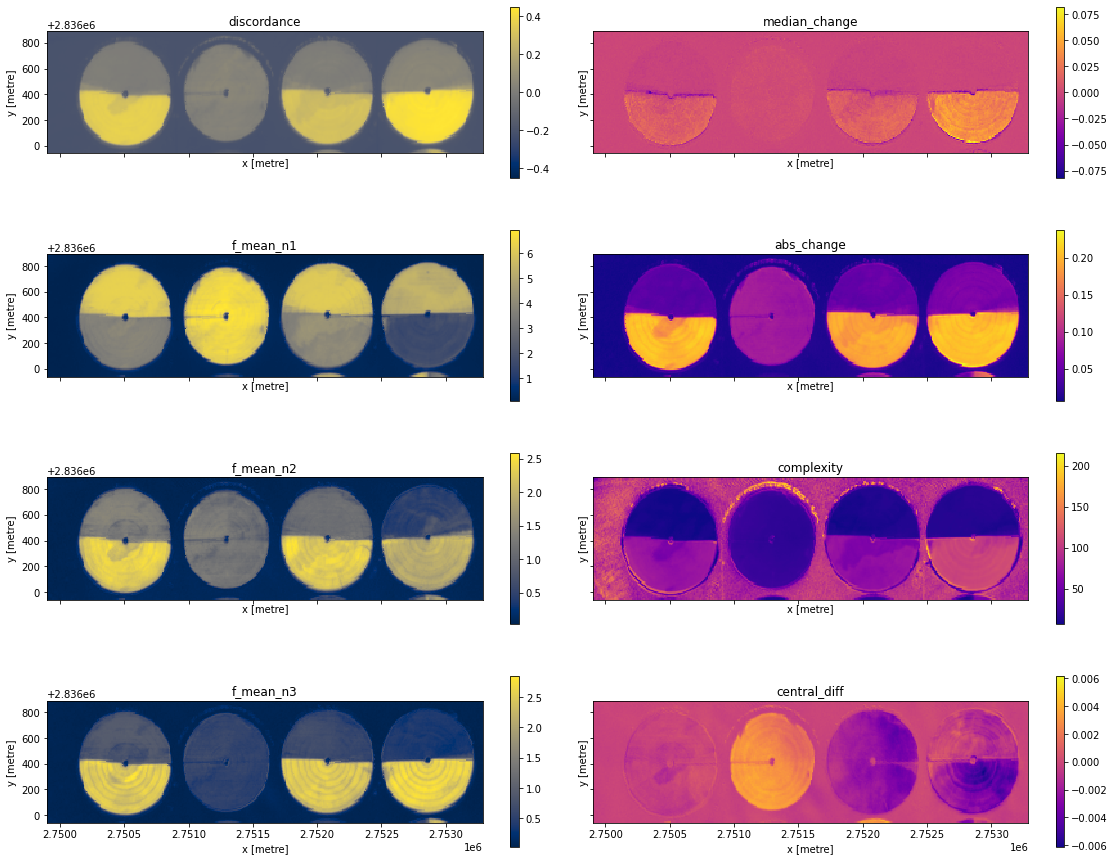

In [33]:
# set up figure
fig, axes = plt.subplots(nrows=4,
                       ncols=2,
                       figsize=(16, 13),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.5

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats = list(ts_stats.data_vars)

#plot
for ax,stat_1,stat_2 in zip(axes, stats[0:4], stats[4:8]):
    ts_stats[stat_1].plot(ax=ax[0],cmap='cividis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    
    ts_stats[stat_2].plot(ax=ax[1],cmap='plasma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)

plt.tight_layout();

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


## Next steps

When you're done, if you wish to run this code for another region, return to the "Analysis parameters" cell, modify some values (e.g. `time_range`,  or `lat`/`lon`) and rerun the analysis.

For advanced users, `xr_phenology` could be used for generating phenology feature layers in a machine learning classifier (see [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) for example of running ML models with ODC data).  `xr_phenology` can be passed inside of the `custom_func` parameter in the `deafrica_classificationtools.collect_training_data()` function, allowing phenological statistics to be computed during the collection of training data. An example would look like this:

    import sys
    sys.path.append('../Scripts')
    from deafrica_temporal_statistics import xr_phenology
    from deafrica_classificationtools import collect_training_data

    def phenology_stats(da):
        stats = xr_phenology(da, complete='fast_complete')
        return stats

    training = collect_training_data(...,
                                     custom_func=phenology_stats)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [34]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [35]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-04-30'